# 모델훈련

In [1]:
!python train.py --help

usage: train.py [-h] --save_path SAVE_PATH [--indices INDICES] [--gpu_id GPU_ID]
                [--train_ratio TRAIN_RATIO] [--batch_size BATCH_SIZE] [--n_epochs N_EPOCHS]

options:
  -h, --help            show this help message and exit
  --save_path SAVE_PATH
  --indices INDICES
  --gpu_id GPU_ID
  --train_ratio TRAIN_RATIO
  --batch_size BATCH_SIZE
  --n_epochs N_EPOCHS


In [2]:
!python train.py --save_path model.pth --gpu_id 0 --batch_size 64 --n_epochs 20

100% 170498071/170498071 [00:12<00:00, 13116181.11it/s]
Extracting ./data/cifar-10-python.tar.gz to ./data
mean_r : 0.4921, mean_g : 0.4827, mean_b : 0.4471
std_r : 0.2470, std_g : 0.2434, std_b : 0.2616
Files already downloaded and verified
Train: 40000
Valid: 10000
Test: 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 32, 32]             896
              ReLU-2           [64, 32, 32, 32]               0
       BatchNorm2d-3           [64, 32, 32, 32]              64
            Conv2d-4           [64, 32, 32, 32]           9,248
              ReLU-5           [64, 32, 32, 32]               0
       BatchNorm2d-6           [64, 32, 32, 32]              64
         MaxPool2d-7           [64, 32, 16, 16]               0
          CNNBlock-8           [64, 32, 16, 16]               0
            Conv2d-9           [64, 64, 16, 16]          18,496
             Re

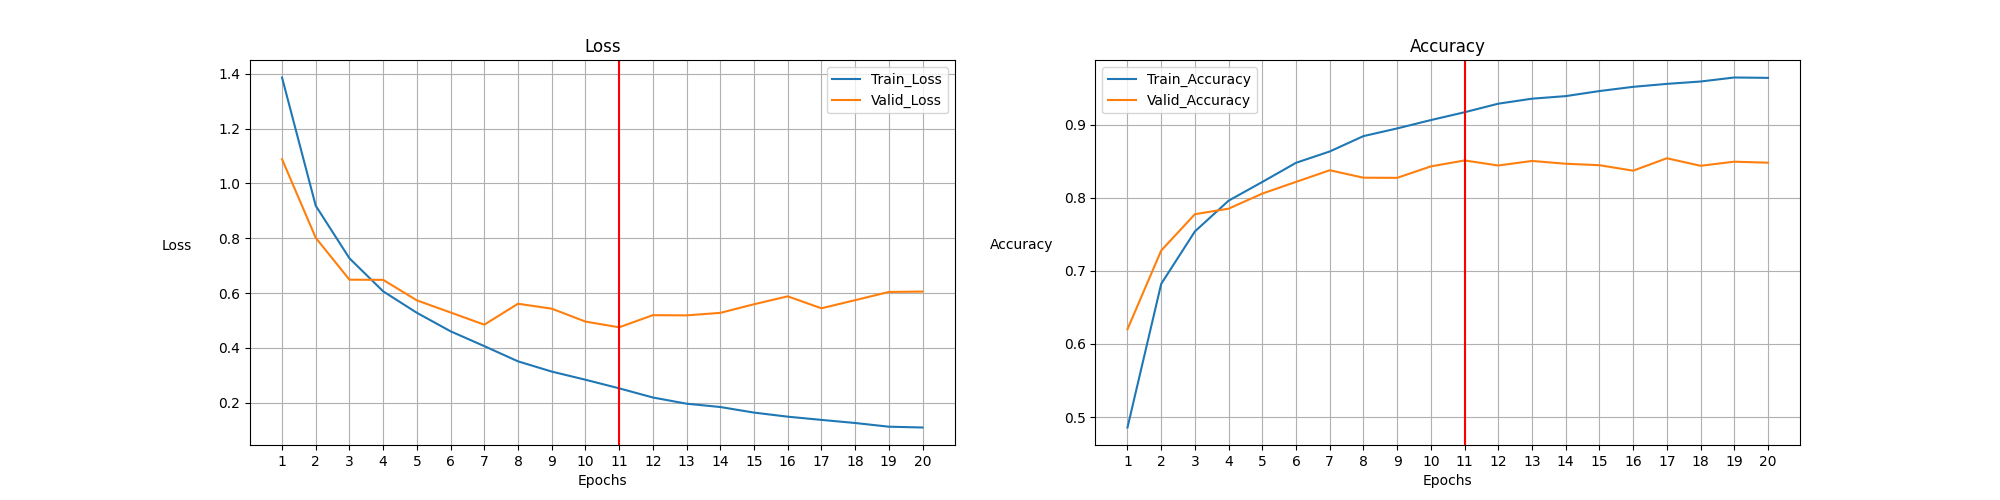

In [3]:
from PIL import Image
Image.open('/content/Training_Graph.png')

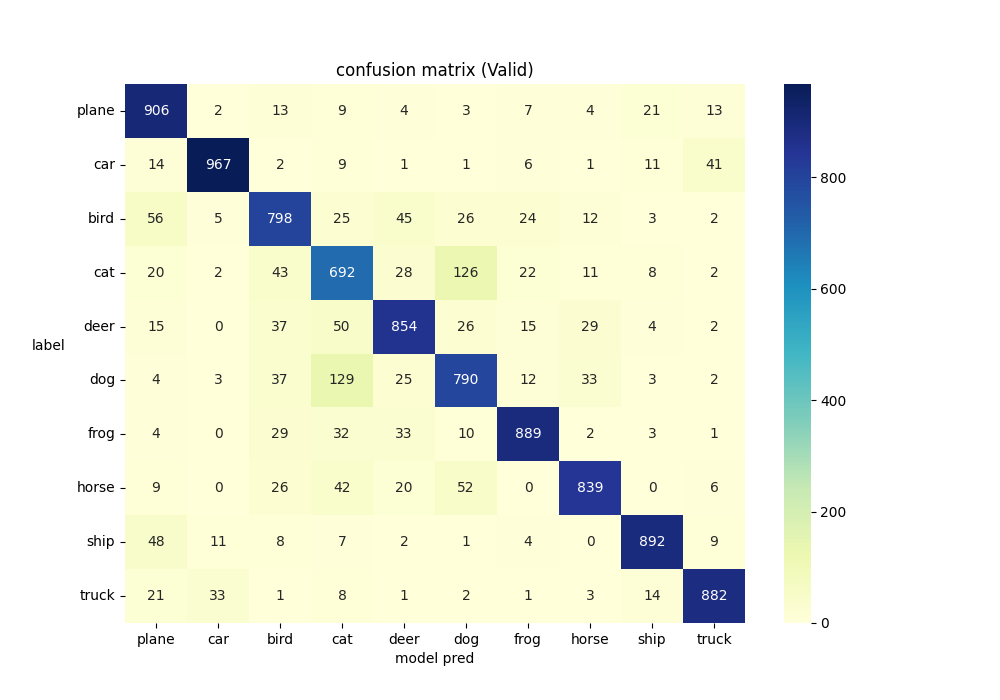

In [4]:
Image.open('/content/confusion_matrix_Valid.png')

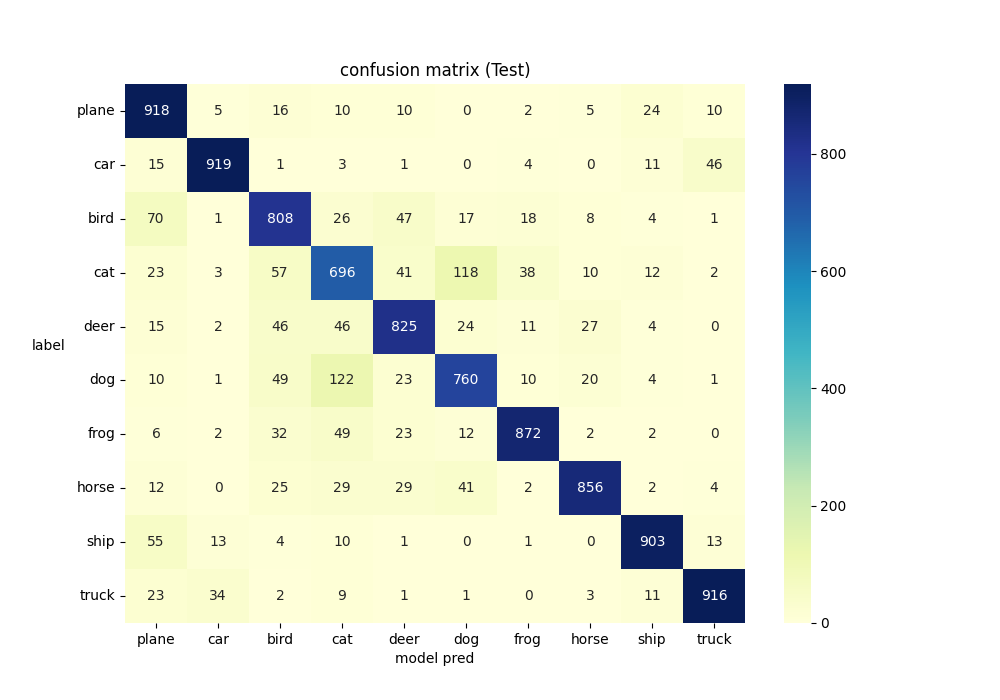

In [5]:
Image.open('/content/confusion_matrix_Test.png')

In [9]:
import pandas as pd
pd.read_excel('result_excel.xlsx', sheet_name = 'Epoch')

,Epoch,Train_Loss,Validation_Loss,Train_Accuracy,Valid_Accuracy
0,1,1.386154,1.088225,0.485800,0.6202
1,2,0.918309,0.801349,0.682175,0.7277
2,3,0.726623,0.648609,0.753850,0.7774
3,4,0.606086,0.648002,0.795900,0.7850
4,5,0.527810,0.573163,0.821500,0.8056
5,6,0.460322,0.528912,0.847675,0.8216
6,7,0.406252,0.484453,0.863175,0.8375
7,8,0.350729,0.560784,0.884175,0.8273
8,9,0.313396,0.542869,0.894675,0.8271
9,10,0.283659,0.495799,0.906100,0.8428


In [8]:
pd.read_excel('result_excel.xlsx', sheet_name = 'Result')

,Phase,Loss,Accuracy
0,Validation,0.474858,0.8509
1,Test,0.488573,0.8473


# 결과 시각화

In [10]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import argparse
import torch

from ipywidgets import interact

from model import CNNModel
from data_loader import get_loaders

In [11]:
args = argparse.Namespace(
  indices='/content/indices.npy',
  train_ratio=0.8,
  batch_size = 64
)

label_name = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ships', 'truck']

train_loader, valid_loader, test_loader = get_loaders(args)
with open('/content/standard_dict.pkl','rb') as r:
  ms_dict = pickle.load(r)
ms_dict

Files already downloaded and verified
mean_r : 0.4921, mean_g : 0.4827, mean_b : 0.4471
std_r : 0.2470, std_g : 0.2434, std_b : 0.2616
Files already downloaded and verified


{'mean': (0.4920571457567402, 0.4826722223498775, 0.44710828536688113),
 'std': (0.24695203440824245, 0.24338970497009688, 0.26157156591092634)}

In [12]:
def inverse_normalize(img, mean=ms_dict['mean'], std=ms_dict['std']):
    new_img = img.copy()

    new_img[:,:,0] = ((new_img[:,:,0]) * std[0]) + mean[0]
    new_img[:,:,1] = ((new_img[:,:,1]) * std[1]) + mean[1]
    new_img[:,:,2] = ((new_img[:,:,2]) * std[2]) + mean[2]
    return (new_img * 255).astype(np.int32)

def batch_extractor(batch_no, model, loader):
  for i, data in enumerate(loader):
    x, y = data
    imgs = x
    labels = y.numpy()
    if i == batch_no - 1:
      break
  with torch.no_grad():
    preds = model(imgs).max(1, keepdim = True)[1].detach().to('cpu').numpy().reshape(-1)
  imgs = np.transpose(imgs.numpy(),(0,2,3,1))
  print(imgs.shape)

  extract_dict = {}
  extract_dict['imgs'] = imgs
  extract_dict['labels'] = labels
  extract_dict['preds'] = preds
  return extract_dict

In [13]:
model = CNNModel(10)
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))
model.eval()

CNNModel(
  (feature_extractor): Sequential(
    (0): CNNBlock(
      (layers): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): CNNBlock(
      (layers): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(64, eps=1e-0

In [14]:
# ValidationSet 시각화
@interact(index = (0, len(valid_loader) -1))
def shower(index = 0):
  extract_dict = batch_extractor(index, model, valid_loader)
  plt.figure(figsize = (20,25))
  for i in range(64):
    if i > len(extract_dict['imgs']) - 1:
      break
    plt.subplot(8,8,i+1)
    plt.imshow(inverse_normalize(extract_dict['imgs'][i]))
    plt.axis('off')
    if extract_dict['preds'][i] == extract_dict['labels'][i]:
      color = "blue"
    else:
      color = "red"
    plt.title(f'Label : {label_name[extract_dict["labels"][i]]}\npred : {label_name[extract_dict["preds"][i]]}', color = color)
  plt.suptitle(f'ValidationSet Label&Pred BatchNo.{index + 1}', y = 0.92, fontsize = 20)
  plt.show()

interactive(children=(IntSlider(value=0, description='index', max=156), Output()), _dom_classes=('widget-inter…

In [15]:
# TestSet 시각화
@interact(index = (0, len(test_loader) -1))
def shower(index = 0):
  extract_dict = batch_extractor(index, model, test_loader)
  plt.figure(figsize = (20,25))
  for i in range(64):
    if i > len(extract_dict['imgs']) - 1:
      break
    plt.subplot(8,8,i+1)
    plt.imshow(inverse_normalize(extract_dict['imgs'][i]))
    plt.axis('off')
    if extract_dict['preds'][i] == extract_dict['labels'][i]:
      color = "blue"
    else:
      color = "red"
    plt.title(f'Label : {label_name[extract_dict["labels"][i]]}\npred : {label_name[extract_dict["preds"][i]]}', color = color)
  plt.suptitle(f'TestSet Label&Pred BatchNo.{index + 1}', y = 0.92, fontsize = 20)
  plt.show()

interactive(children=(IntSlider(value=0, description='index', max=156), Output()), _dom_classes=('widget-inter…